In [2]:

pip install agml


Note: you may need to restart the kernel to use updated packages.


In [3]:
import agml.data as data
print(dir(data))


['AgMLDataLoader', 'ImageLoader', 'PointCloud', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'builder', 'coco_to_bboxes', 'convert_bbox_format', 'download_public_dataset', 'experimental', 'exporters', 'extensions', 'image_loader', 'loader', 'manager', 'managers', 'metadata', 'object', 'point_cloud', 'public', 'public_data_sources', 'source', 'tools']


In [4]:
from agml.data import download_public_dataset

download_public_dataset('plant_village_classification')


/home/itartoussi/miniconda3/envs/agml_env_312/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
05-29-2025 23:15:46 WARNING - root: [AgML] Dataset 'plant_village_classification' already exists in '/home/itartoussi/.agml/datasets/plant_village_classification', skipping download.


'/home/itartoussi/.agml/datasets'

Total samples: 55448


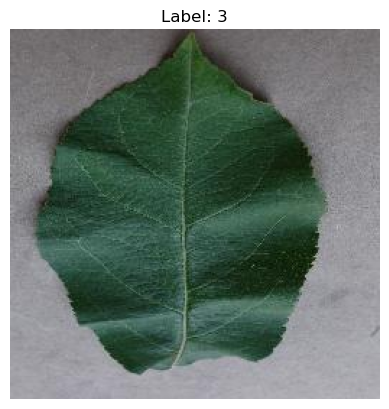

In [5]:
from agml.data import AgMLDataLoader

loader = AgMLDataLoader('plant_village_classification')

print("Total samples:", len(loader))

# Example: show first image and label
import matplotlib.pyplot as plt

image, label = loader[0]
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


In [6]:
import torch
print(torch.__version__)


2.5.1


In [7]:
from agml.data import AgMLDataLoader

loader = AgMLDataLoader('plant_village_classification')


In [8]:
import torch
import torch.nn as nn


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(x_cat))
        return x * attention


In [9]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

class MobileNetV2WithSA(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2WithSA, self).__init__()
        self.mobilenet = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        self.spatial_attention = SpatialAttention()
        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.mobilenet.features(x)          # Backbone features
        x = self.spatial_attention(x)           # Apply Spatial Attention
        x = x.mean([2, 3])                       # Global Average Pooling
        x = self.classifier(x)                  # Classification
        return x


In [10]:
from collections import Counter

label_counter = Counter()
for _, label in loader:
    label_counter[label] += 1

print(f"Number of classes: {len(label_counter)}")
print(label_counter)


Number of classes: 39
Counter({16: 5507, 36: 5357, 25: 5090, 17: 2297, 29: 2127, 31: 1909, 26: 1835, 33: 1771, 34: 1676, 3: 1645, 38: 1591, 5: 1502, 20: 1478, 35: 1404, 13: 1383, 9: 1192, 12: 1180, 11: 1162, 4: 1143, 27: 1109, 14: 1076, 6: 1052, 21: 1000, 30: 1000, 22: 1000, 19: 997, 10: 985, 32: 952, 7: 854, 0: 630, 1: 621, 8: 513, 28: 456, 15: 423, 37: 373, 24: 371, 18: 360, 2: 275, 23: 152})


Total samples: 55448
Number of classes: 39


05-29-2025 23:19:58 WARNING - matplotlib.image: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.45320535].


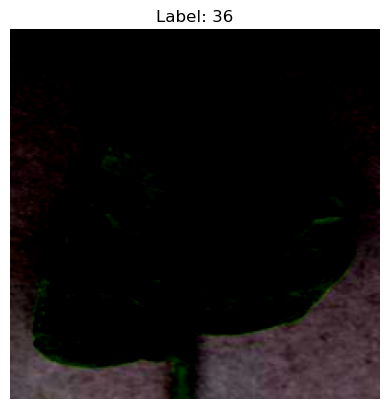

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from agml.data import AgMLDataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# التحميل من AgML
agml_loader = AgMLDataLoader('plant_village_classification')

# عدد الكلاسات
num_classes = len(set(label for _, label in agml_loader))
print(f"Total samples: {len(agml_loader)}")
print(f"Number of classes: {num_classes}")

# التحويل إلى Dataset مخصص
class AgMLTorchDataset(Dataset):
    def __init__(self, agml_loader, transform=None):
        self.agml_loader = agml_loader
        self.transform = transform

    def __len__(self):
        return len(self.agml_loader)

    def __getitem__(self, idx):
        image, label = self.agml_loader[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformات للصورة
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # مناسب لموديلات مثل MobileNet
    transforms.Normalize(mean=[0.5], std=[0.5])  # تقدر تعدلها حسب بياناتك
])

# تجهيز الداتا
full_dataset = AgMLTorchDataset(agml_loader, transform=transform)

# Split إلى train/test بنسبة 80/20
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# تأكد من أن كل شيء يعمل بعرض صورة من الـ train loader
sample_img, sample_label = next(iter(train_loader))
plt.imshow(sample_img[0].permute(1, 2, 0))  # من (C, H, W) إلى (H, W, C)
plt.title(f"Label: {sample_label[0].item()}")
plt.axis('off')
plt.show()


In [12]:
import torch
import torch.nn as nn
from torchvision import models  # انت استوردت models

# عدد الكلاسات
NUM_CLASSES = 39  # غير الرقم حسب بياناتك

# تحميل MobileNetV2 مع الأوزان
from torchvision.models import MobileNet_V2_Weights
weights = MobileNet_V2_Weights.IMAGENET1K_V1
model = models.mobilenet_v2(weights=weights)  # استعمل models وليس torchvision.models

# تجميد الميزات (اختياري)
for param in model.features.parameters():
    param.requires_grad = True

# تعديل الطبقة الأخيرة للتصنيف
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, NUM_CLASSES)
)

# إرسال إلى الجهاز المناسب
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



In [13]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [14]:
import os

base_path = '/home/itartoussi/.agml/datasets/plant_village_classification'
print(os.listdir(base_path))


['Grape___healthy', 'Apple___Cedar_apple_rust', 'Blueberry___healthy', 'Strawberry___healthy', 'Pepper,_bell___Bacterial_spot', 'Apple___healthy', 'Tomato___Early_blight', 'Tomato___Bacterial_spot', 'Raspberry___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Strawberry___Leaf_scorch', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Pepper,_bell___healthy', 'Apple___Apple_scab', 'Peach___healthy', 'Grape___Esca_(Black_Measles)', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Corn___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Squash___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Background_without_leaves', 'Apple___Black_rot', 'Corn___Northern_Leaf_Blight', 'Potato___Early_blight', 'Potato___Late_blight', 'Grape___Black_rot', 'Corn___Common_rust', 'Potato___healthy', 'Tomato___Leaf_Mold', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Peach___Bacterial_spot', 'Tomato___healthy', 'Soybean___heal

In [15]:
original_dataset_dir = '/home/itartoussi/.agml/datasets/plant_village_classification'


In [16]:
import os
import shutil
import random

original_dataset_dir = '/home/itartoussi/.agml/datasets/plant_village_classification'
base_dir = 'dataset_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

split_ratio = 0.8

for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    random.shuffle(images)

    split_point = int(len(images) * split_ratio)
    train_imgs = images[:split_point]
    val_imgs = images[split_point:]

    train_class_dir = os.path.join(train_dir, class_name)
    val_class_dir = os.path.join(val_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    for img_name in train_imgs:
        src = os.path.join(class_path, img_name)
        dst = os.path.join(train_class_dir, img_name)
        shutil.copy2(src, dst)

    for img_name in val_imgs:
        src = os.path.join(class_path, img_name)
        dst = os.path.join(val_class_dir, img_name)
        shutil.copy2(src, dst)

print("✅ تم تقسيم الصور بنجاح إلى train و val")


✅ تم تقسيم الصور بنجاح إلى train و val


In [17]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# التحويلات (مع إمكانية إضافة augmentations لاحقاً)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# تحميل البيانات
train_dataset = datasets.ImageFolder(root='dataset_split/train', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset_split/val', transform=transform)

# إنشاء dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# عدد الكلاسات
NUM_CLASSES = len(train_dataset.classes)
print(f"عدد الكلاسات: {NUM_CLASSES}")


عدد الكلاسات: 39


In [19]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



Classification Report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.00      0.00      0.00       126
                            Apple___Black_rot       0.00      0.00      0.00       125
                     Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                              Apple___healthy       0.00      0.00      0.00       329
                    Background_without_leaves       0.08      0.20      0.12       229
                          Blueberry___healthy       0.01      0.00      0.01       301
                      Cherry___Powdery_mildew       0.00      0.00      0.00       211
                             Cherry___healthy       0.00      0.00      0.00       171
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00       103
                           Corn___Common_rust       0.00      0.00      0.00       239
                  

/home/itartoussi/miniconda3/envs/agml_env_312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/itartoussi/miniconda3/envs/agml_env_312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/itartoussi/miniconda3/envs/agml_env_312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

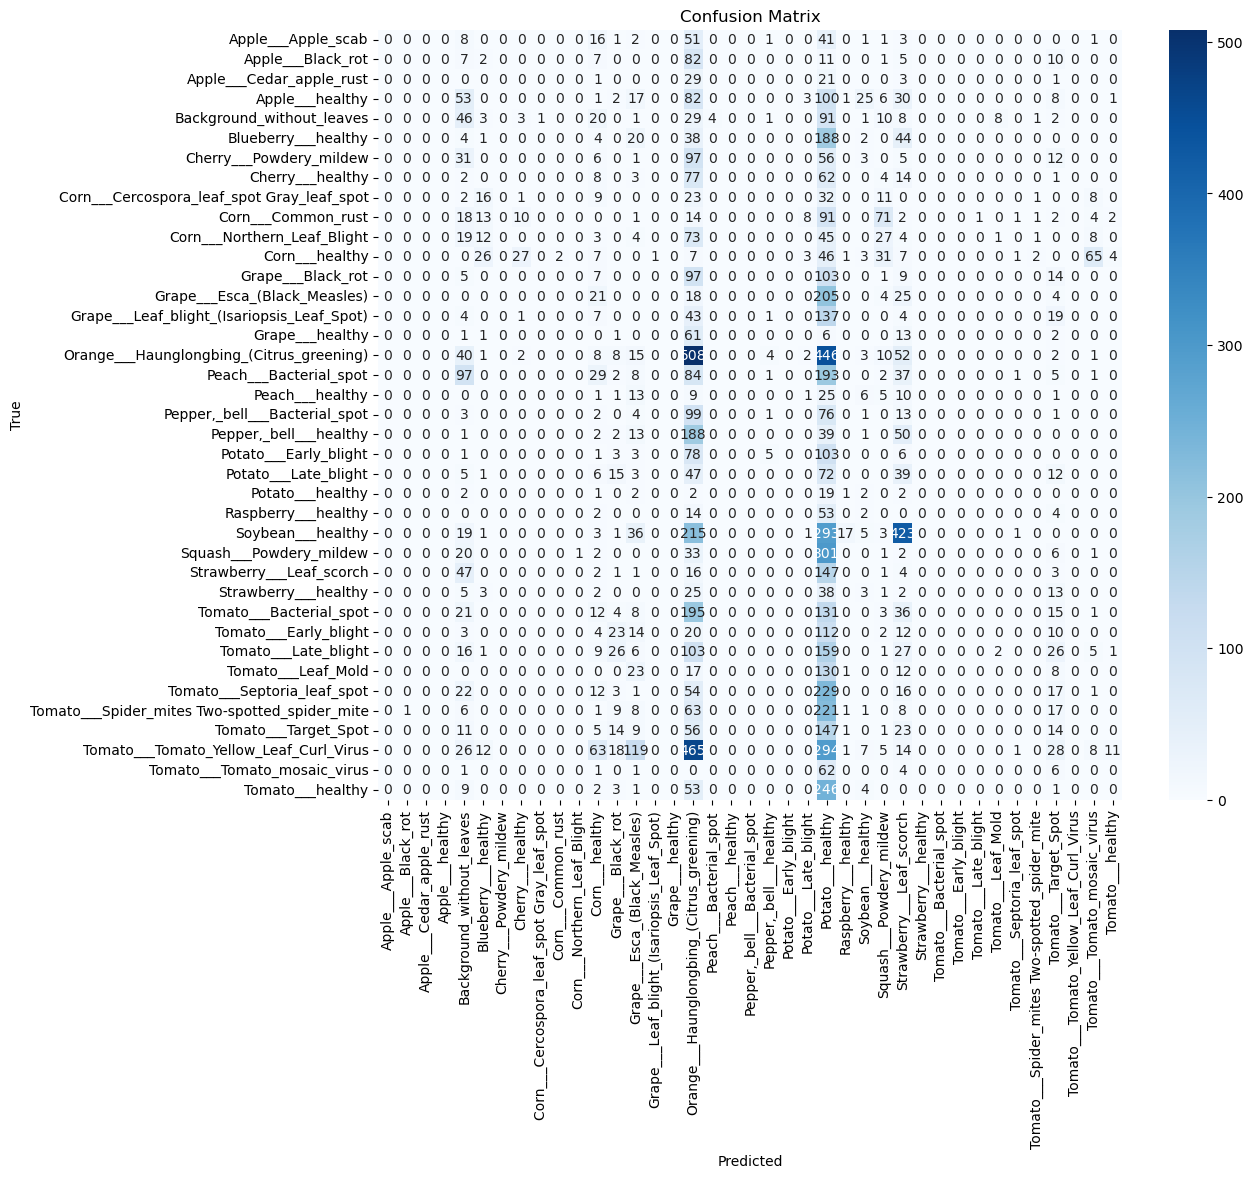

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# بعد الانتهاء من التدريب (من all_preds و all_labels)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms, models
from torchvision.models import MobileNet_V2_Weights
from tqdm import tqdm
import numpy as np
import os

# تحديد الجهاز
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# تحميل MobileNetV2 مع الأوزان المسبقة
weights = MobileNet_V2_Weights.DEFAULT
model = models.mobilenet_v2(weights=weights)

# إعداد التحويلات
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    weights.transforms()
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    weights.transforms()
])

# تحميل كل البيانات
full_train_dataset = datasets.ImageFolder('dataset_split/train', transform=train_transforms)
full_val_dataset = datasets.ImageFolder('dataset_split/val', transform=val_transforms)

# اختيار الأصناف المطلوبة
selected_classes = ['Tomato___Late_blight', 'Potato___Early_blight']
selected_class_indices = [full_train_dataset.class_to_idx[cls] for cls in selected_classes]
index_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(selected_class_indices)}

# كلاس جديد لإعادة ترقيم اللايبلات
class ReindexedSubset(Dataset):
    def __init__(self, subset, class_indices_mapping):
        self.subset = subset
        self.mapping = class_indices_mapping

    def __getitem__(self, index):
        x, y = self.subset[index]
        y = self.mapping[y]
        return x, y

    def __len__(self):
        return len(self.subset)

# فلترة وإعادة الترقيم
def filter_and_remap(dataset, class_indices, mapping):
    indices = [i for i, (_, label) in enumerate(dataset) if label in class_indices]
    subset = Subset(dataset, indices)
    return ReindexedSubset(subset, mapping)

train_dataset = filter_and_remap(full_train_dataset, selected_class_indices, index_mapping)
val_dataset = filter_and_remap(full_val_dataset, selected_class_indices, index_mapping)

# محمّلات البيانات
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# تعديل الطبقة النهائية في MobileNetV2
model.classifier[1] = nn.Linear(model.last_channel, len(selected_classes))
model = model.to(device)

# تحديد الخسارة والمُحسّن والجدولة
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# التدريب
NUM_EPOCHS = 100
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    scheduler.step()
    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # التقييم
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.4f}")


Epoch 1/100: 100%|██████████| 73/73 [01:24<00:00,  1.16s/it]


Epoch [1/100], Loss: 3.6859, Train Accuracy: 0.9832
Validation Accuracy: 1.0000


Epoch 2/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [2/100], Loss: 2.5836, Train Accuracy: 0.9905
Validation Accuracy: 1.0000


Epoch 3/100: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Epoch [3/100], Loss: 0.8834, Train Accuracy: 0.9970
Validation Accuracy: 1.0000


Epoch 4/100: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]


Epoch [4/100], Loss: 0.3721, Train Accuracy: 0.9983
Validation Accuracy: 1.0000


Epoch 5/100: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Epoch [5/100], Loss: 0.2874, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 6/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [6/100], Loss: 0.1952, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 7/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [7/100], Loss: 0.3693, Train Accuracy: 0.9983
Validation Accuracy: 1.0000


Epoch 8/100: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Epoch [8/100], Loss: 0.1728, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 9/100: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Epoch [9/100], Loss: 0.1497, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 10/100: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Epoch [10/100], Loss: 0.1632, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 11/100: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Epoch [11/100], Loss: 0.1617, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 12/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [12/100], Loss: 0.1892, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 13/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [13/100], Loss: 0.1604, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 14/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [14/100], Loss: 0.2771, Train Accuracy: 0.9983
Validation Accuracy: 1.0000


Epoch 15/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [15/100], Loss: 0.1857, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 16/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [16/100], Loss: 0.2874, Train Accuracy: 0.9987
Validation Accuracy: 1.0000


Epoch 17/100: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Epoch [17/100], Loss: 0.3067, Train Accuracy: 0.9991
Validation Accuracy: 1.0000


Epoch 18/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [18/100], Loss: 0.2953, Train Accuracy: 0.9991
Validation Accuracy: 1.0000


Epoch 19/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [19/100], Loss: 0.2438, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 20/100: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Epoch [20/100], Loss: 0.1298, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 21/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [21/100], Loss: 0.4743, Train Accuracy: 0.9987
Validation Accuracy: 1.0000


Epoch 22/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [22/100], Loss: 0.1283, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 23/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [23/100], Loss: 0.1451, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 24/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [24/100], Loss: 0.2287, Train Accuracy: 0.9991
Validation Accuracy: 1.0000


Epoch 25/100: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Epoch [25/100], Loss: 0.2231, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 26/100: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Epoch [26/100], Loss: 0.1730, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 27/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [27/100], Loss: 0.2264, Train Accuracy: 0.9991
Validation Accuracy: 1.0000


Epoch 28/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [28/100], Loss: 0.1353, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 29/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [29/100], Loss: 0.1130, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 30/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [30/100], Loss: 0.1626, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 31/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [31/100], Loss: 0.1516, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 32/100: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Epoch [32/100], Loss: 0.1594, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 33/100: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Epoch [33/100], Loss: 0.4220, Train Accuracy: 0.9991
Validation Accuracy: 1.0000


Epoch 34/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [34/100], Loss: 0.1637, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 35/100: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Epoch [35/100], Loss: 0.1891, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 36/100: 100%|██████████| 73/73 [01:22<00:00,  1.13s/it]


Epoch [36/100], Loss: 0.5999, Train Accuracy: 0.9983
Validation Accuracy: 1.0000


Epoch 37/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [37/100], Loss: 0.1301, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 38/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [38/100], Loss: 0.2284, Train Accuracy: 0.9987
Validation Accuracy: 1.0000


Epoch 39/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [39/100], Loss: 0.2622, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 40/100: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Epoch [40/100], Loss: 0.1736, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 41/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [41/100], Loss: 0.1792, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 42/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [42/100], Loss: 0.1581, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 43/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [43/100], Loss: 0.3811, Train Accuracy: 0.9987
Validation Accuracy: 1.0000


Epoch 44/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [44/100], Loss: 0.2733, Train Accuracy: 0.9987
Validation Accuracy: 1.0000


Epoch 45/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [45/100], Loss: 0.2138, Train Accuracy: 0.9991
Validation Accuracy: 1.0000


Epoch 46/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [46/100], Loss: 0.2275, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 47/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [47/100], Loss: 0.1778, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 48/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [48/100], Loss: 0.3898, Train Accuracy: 0.9983
Validation Accuracy: 1.0000


Epoch 49/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [49/100], Loss: 0.1503, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 50/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [50/100], Loss: 0.2271, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 51/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [51/100], Loss: 0.1866, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 52/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [52/100], Loss: 0.1527, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 53/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [53/100], Loss: 0.1634, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 54/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [54/100], Loss: 0.3897, Train Accuracy: 0.9987
Validation Accuracy: 1.0000


Epoch 55/100: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Epoch [55/100], Loss: 0.1577, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 56/100: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Epoch [56/100], Loss: 0.1572, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 57/100: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Epoch [57/100], Loss: 0.3624, Train Accuracy: 0.9987
Validation Accuracy: 1.0000


Epoch 58/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [58/100], Loss: 0.4450, Train Accuracy: 0.9983
Validation Accuracy: 1.0000


Epoch 59/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [59/100], Loss: 0.3400, Train Accuracy: 0.9987
Validation Accuracy: 1.0000


Epoch 60/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [60/100], Loss: 0.1754, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 61/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [61/100], Loss: 0.1801, Train Accuracy: 0.9991
Validation Accuracy: 1.0000


Epoch 62/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [62/100], Loss: 0.2399, Train Accuracy: 0.9987
Validation Accuracy: 1.0000


Epoch 63/100: 100%|██████████| 73/73 [01:22<00:00,  1.13s/it]


Epoch [63/100], Loss: 0.2294, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 64/100: 100%|██████████| 73/73 [01:22<00:00,  1.13s/it]


Epoch [64/100], Loss: 0.1360, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 65/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [65/100], Loss: 0.1523, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 66/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [66/100], Loss: 0.2083, Train Accuracy: 0.9991
Validation Accuracy: 1.0000


Epoch 67/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [67/100], Loss: 0.1471, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 68/100: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Epoch [68/100], Loss: 0.1976, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 69/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [69/100], Loss: 0.2599, Train Accuracy: 0.9987
Validation Accuracy: 1.0000


Epoch 70/100: 100%|██████████| 73/73 [01:22<00:00,  1.13s/it]


Epoch [70/100], Loss: 0.2045, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 71/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [71/100], Loss: 0.2102, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 72/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [72/100], Loss: 0.2283, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 73/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [73/100], Loss: 0.3120, Train Accuracy: 0.9987
Validation Accuracy: 1.0000


Epoch 74/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [74/100], Loss: 0.1445, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 75/100: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Epoch [75/100], Loss: 0.1579, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 76/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [76/100], Loss: 0.1549, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 77/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [77/100], Loss: 0.2276, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 78/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [78/100], Loss: 0.2156, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 79/100: 100%|██████████| 73/73 [01:22<00:00,  1.12s/it]


Epoch [79/100], Loss: 0.1322, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 80/100: 100%|██████████| 73/73 [01:22<00:00,  1.12s/it]


Epoch [80/100], Loss: 0.1843, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 81/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [81/100], Loss: 0.1671, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 82/100: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Epoch [82/100], Loss: 0.1362, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 83/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [83/100], Loss: 0.1415, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 84/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [84/100], Loss: 0.1457, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 85/100: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Epoch [85/100], Loss: 0.1267, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 86/100: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Epoch [86/100], Loss: 0.2623, Train Accuracy: 0.9991
Validation Accuracy: 1.0000


Epoch 87/100: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Epoch [87/100], Loss: 0.2028, Train Accuracy: 0.9991
Validation Accuracy: 1.0000


Epoch 88/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [88/100], Loss: 0.2514, Train Accuracy: 0.9991
Validation Accuracy: 1.0000


Epoch 89/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [89/100], Loss: 0.1722, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 90/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [90/100], Loss: 0.1854, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 91/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [91/100], Loss: 0.3072, Train Accuracy: 0.9991
Validation Accuracy: 1.0000


Epoch 92/100: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Epoch [92/100], Loss: 0.2243, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 93/100: 100%|██████████| 73/73 [01:20<00:00,  1.11s/it]


Epoch [93/100], Loss: 0.2837, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 94/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [94/100], Loss: 0.1452, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 95/100: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Epoch [95/100], Loss: 0.2482, Train Accuracy: 0.9987
Validation Accuracy: 1.0000


Epoch 96/100: 100%|██████████| 73/73 [01:20<00:00,  1.10s/it]


Epoch [96/100], Loss: 0.1648, Train Accuracy: 0.9996
Validation Accuracy: 1.0000


Epoch 97/100: 100%|██████████| 73/73 [01:21<00:00,  1.11s/it]


Epoch [97/100], Loss: 0.1676, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 98/100: 100%|██████████| 73/73 [01:21<00:00,  1.12s/it]


Epoch [98/100], Loss: 0.1465, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 99/100: 100%|██████████| 73/73 [01:19<00:00,  1.10s/it]


Epoch [99/100], Loss: 0.1473, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


Epoch 100/100: 100%|██████████| 73/73 [01:22<00:00,  1.13s/it]


Epoch [100/100], Loss: 0.1462, Train Accuracy: 1.0000
Validation Accuracy: 1.0000


/tmp/ipykernel_1624375/1806590158.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/itartoussi/classification/project/notebooks/mo

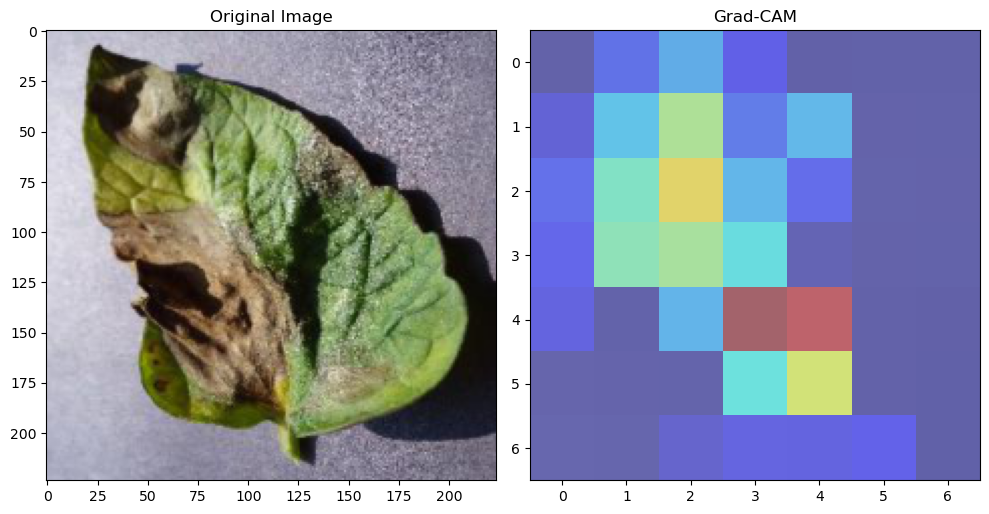

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
val_dataset = datasets.ImageFolder('dataset_split/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

# ----- تحميل النموذج -----
model = models.mobilenet_v2(num_classes=2)  # غيّري num_classes حسب الأصناف
model.load_state_dict(torch.load('/home/itartoussi/classification/project/notebooks/mobilenet_v2_base.pth', map_location='cpu'))
model.eval()

full_train_dataset = datasets.ImageFolder('dataset_split/train', transform=transform)
full_val_dataset = datasets.ImageFolder('dataset_split/val', transform=transform)

selected_classes = ['Tomato___Late_blight', 'Potato___Early_blight']
selected_class_indices = [full_train_dataset.class_to_idx[cls] for cls in selected_classes]
index_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(selected_class_indices)}

filtered_val_indices = [i for i, (_, label) in enumerate(full_val_dataset.samples) if label in selected_class_indices]
filtered_val_dataset = torch.utils.data.Subset(full_val_dataset, filtered_val_indices)

val_loader = DataLoader(filtered_val_dataset, batch_size=1, shuffle=True)

def generate_gradcam(model, image, class_idx):
    image = image.unsqueeze(0)
    model.eval()

    activations = None
    gradients = None

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    handle_fw = model.features[-1].register_forward_hook(forward_hook)
    handle_bw = model.features[-1].register_backward_hook(backward_hook)

    output = model(image)
    if class_idx is None:
        class_idx = output.argmax(dim=1).item()

    model.zero_grad()
    class_score = output[0, class_idx]
    class_score.backward()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = torch.nn.functional.relu(heatmap)
    heatmap = heatmap / torch.max(heatmap)
    heatmap = heatmap.detach().cpu().numpy()

    handle_fw.remove()
    handle_bw.remove()

    return heatmap

sample_img, sample_label = next(iter(val_loader))
gradcam = generate_gradcam(model, sample_img.squeeze(0), index_mapping[sample_label.item()])

original_img = sample_img.squeeze(0).permute(1, 2, 0).numpy()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(original_img)
plt.imshow(gradcam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM")
plt.tight_layout()
plt.show()


/tmp/ipykernel_1722257/1356989245.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/home/itartoussi/classification/project/notebooks/mo

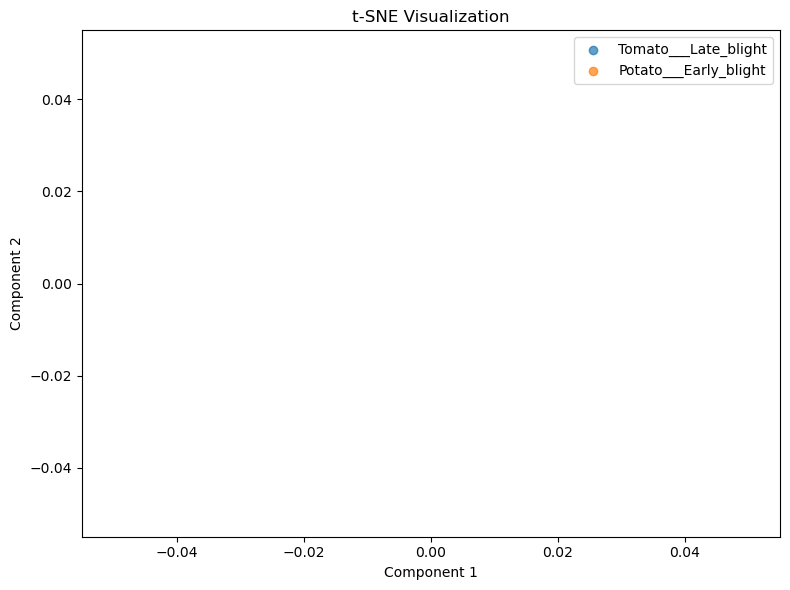

In [3]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# ----- إعداد التحويلات -----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ----- تحميل النموذج -----
model = models.mobilenet_v2(num_classes=2)
model.load_state_dict(torch.load('/home/itartoussi/classification/project/notebooks/mobilenet_v2_base.pth', map_location='cpu'))
model.eval()

# ----- تحميل البيانات -----
full_val_dataset = datasets.ImageFolder('dataset_split/val', transform=transform)
selected_classes = ['Tomato___Late_blight', 'Potato___Early_blight']
selected_class_indices = [full_val_dataset.class_to_idx[cls] for cls in selected_classes]
index_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(selected_class_indices)}

# تصفية فقط الأصناف المطلوبة
filtered_val_samples = [(img, index_mapping[label]) for img, label in full_val_dataset.samples if label in selected_class_indices]
filtered_val_dataset = torch.utils.data.Subset(full_val_dataset, [i for i, (path, label) in enumerate(full_val_dataset.samples) if label in selected_class_indices])
val_loader = DataLoader(filtered_val_dataset, batch_size=32, shuffle=False)

# ----- استخراج الميزات -----
def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model.features(inputs)
            outputs = torch.nn.functional.adaptive_avg_pool2d(outputs, (1, 1))
            outputs = outputs.view(outputs.size(0), -1)
            features.append(outputs.cpu())
            labels.append(targets)

    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    return features, labels

# ----- رسم t-SNE -----
def plot_tsne(features, labels, class_names):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    tsne_result = tsne.fit_transform(features)

    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(class_names):
        idxs = np.where(labels == i)
        plt.scatter(tsne_result[idxs, 0], tsne_result[idxs, 1], label=class_name, alpha=0.7)
    plt.legend()
    plt.title("t-SNE Visualization")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.tight_layout()
    plt.show()

# ----- التشغيل -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

features, labels = extract_features(model, val_loader, device)
plot_tsne(features, labels, selected_classes)
